# Imports

In [1]:
import math
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from data_loader import DataLoader
from collections import defaultdict
from json import JSONEncoder
from helpers import select_n_components

plt.style.use('ggplot')
sns.set_palette('tab10')

[nltk_data] Downloading package stopwords to
[nltk_data]     /afs/inf.ed.ac.uk/user/s21/s2125219/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
df, _, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=False)
df.head()

  1%|▏         | 3535/239073 [00:00<00:06, 35341.02it/s]

Preprocessing...


100%|██████████| 239073/239073 [00:05<00:00, 42492.15it/s]


,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
142654,124858,"it 's not very interesting . As a remake , it ...",interesting . As remake pale imitation .,0.20833,2.0,Negative
88224,29530,being grown up,grown,0.55556,3.0,Neutral
161157,34912,nicely nuanced narrative,nicely nuanced narrative,0.73611,4.0,Positive
29109,223464,García Bernal and Talancón are an immensely ap...,Garca Bernal Talancn immensely appealing couple,0.77778,4.0,Positive
68887,228115,a regurgitation of cinematic violence that giv...,regurgitation cinematic violence gives brutal ...,0.55556,3.0,Neutral


In [3]:
df.shape

(142410, 6)

# Helper functions

In [34]:
def plot_stats(stats, xlabel, ylabel, title, save_fig=False):
    fig, ax = plt.subplots(figsize = (8,4))
    
    ax = stats.mean().plot(kind='bar', alpha=0.65)
    ax = stats.median().plot(kind='bar', alpha=0.65)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.legend(['Mean', 'Median'])
    
    if save_fig:
        plt.savefig('mean_med', dpi=300)

# Duplicates

In [35]:
class PhraseCount:
    def __init__(self):
        self.label = ""
        self.count = 0
        
class Encoder(JSONEncoder):
    def default(self, o):
        return o.__dict__

def get_phrase_counts(df):
    phrase_count = defaultdict(PhraseCount)
    
    for p, l in zip(df['phrase_clean'], df['label']):
        phrase_count[p].label = l
        phrase_count[p].count += 1
        
    return phrase_count
    
def get_duplicates(df):  
    neutral_counts = []
    neutral_lens = []

    very_neg_counts = []
    very_neg_lens = []

    neg_counts = []
    neg_lens = []

    very_pos_counts = []
    very_pos_lens = []

    pos_counts = []
    pos_lens = []

    phrase_count = get_phrase_counts(df)
    
    for k, v in json.loads(Encoder().encode(phrase_count)).items():
        if v['count'] > 1:
            if v['label'] == 'Neutral':
                neutral_counts.append(v['count'])
                neutral_lens.append(len(k.split()))
            if v['label'] == 'Very negative':
                very_neg_counts.append(v['count'])
                very_neg_lens.append(len(k.split()))
            if v['label'] == 'Negative':
                neg_counts.append(v['count'])
                neg_lens.append(len(k.split()))
            if v['label'] == 'Very positive':
                very_pos_counts.append(v['count'])
                very_pos_lens.append(len(k.split()))
            if v['label'] == 'Positive':
                pos_counts.append(v['count'])
                pos_lens.append(len(k.split()))
    
    return neutral_counts, neutral_lens, very_neg_counts, very_neg_lens, neg_counts, neg_lens, very_pos_counts, very_pos_lens, pos_counts, pos_lens

neutral_counts, neutral_lens, very_neg_counts, very_neg_lens, neg_counts, neg_lens, very_pos_counts, very_pos_lens, pos_counts, pos_lens = get_duplicates(df)

total_neutral = df[df['label'] == 'Neutral'].shape[0]
total_very_neg = df[df['label'] == 'Very negative'].shape[0]
total_neg = df[df['label'] == 'Negative'].shape[0]
total_very_pos = df[df['label'] == 'Very positive'].shape[0]
total_pos = df[df['label'] == 'Positive'].shape[0]

duplicates = [sum(neutral_counts), sum(pos_counts), sum(neg_counts), sum(very_pos_counts), sum(very_neg_counts)]

In [36]:
np.mean(neutral_lens), np.mean(very_neg_lens), np.mean(neg_lens), np.mean(very_pos_lens), np.mean(pos_lens)

(3.0275156666426564,
 6.055343511450381,
 4.681876332622601,
 5.311023622047244,
 4.322291853178156)

In [37]:
np.median(neutral_lens), np.median(very_neg_lens), np.median(neg_lens), np.median(very_pos_lens), np.median(pos_lens)

(2.0, 5.0, 4.0, 4.0, 3.0)

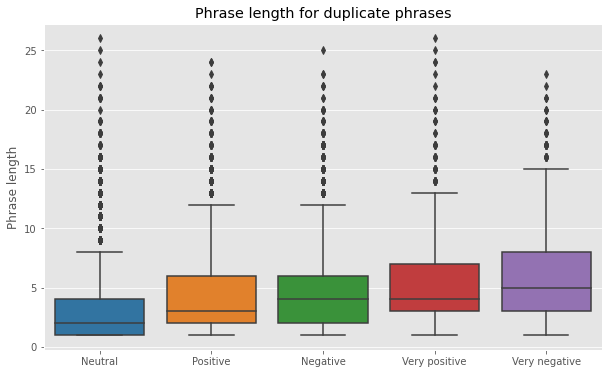

In [63]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(data=[neutral_lens, pos_lens, neg_lens, very_pos_lens, very_neg_lens])
plt.title('Phrase length for duplicate phrases')
plt.ylabel('Phrase length')

plt.xticks(ticks=[0, 1, 2, 3, 4], 
           labels=['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'],
           rotation=0)

plt.savefig('phrase_len', dpi=300)

In [58]:
totals = [total_neutral, total_pos, total_neg, total_very_pos, total_very_neg]

In [59]:
dupls = pd.DataFrame({'Total': totals, 'Duplicate': duplicates})

In [60]:
dupls['Total'].sum(), dupls['Duplicate'].sum()

(142410, 65132)

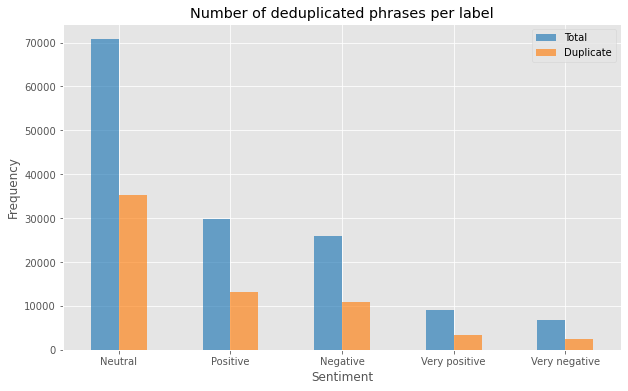

In [61]:
ax = dupls.plot(kind='bar', stacked=False, alpha=0.65, figsize=(10,6))
ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=0)
ax.set_title('Number of deduplicated phrases per label')
ax.set_ylabel('Frequency')
ax.set_xlabel('Sentiment')

plt.savefig('dupls', dpi=300)

In [49]:
phrases_to_dedup = []

phrase_count = get_phrase_counts(df)

for k, v in json.loads(Encoder().encode(phrase_count)).items():
    if v['count'] > 1: # Duplicates
        if len(k.split()) > 4:
            if v['label'] == 'Positive':
                phrases_to_dedup.append(k)

In [50]:
phrases_to_dedup[:50]

['holds era computergenerated images norm',
 'Russell Dreyfus romantic pairing hearts preciously exposed history corners .',
 'marks outstanding feature debut writerdirector Eric Byler understands power implicit virtues simplicity economy .',
 'This romantic thriller steeped atmosphere wartime England',
 'ominous pervasive unknown threat lurks proceedings adds almost constant mindset suspense',
 'rarely stoops cheap manipulation corny conventions',
 'growing nt see often enough days',
 'The film affords us intriguing glimpses insights gleaned lifetime spiritual inquiry',
 'looks much fun slapstick antics silly street patois tossing around obscure expressions like Bellini Mullinski',
 'introduces viewers good charitable enterprise interesting real people',
 'almost spooky sulky calculating Lolita turn',
 'updating White dry wit new age',
 'movie steeped ambiguity lends conflicts symbolic resonance',
 'accurate say I found intriguing bizarre Dogmalike spots quite truthful way',
 'The mov

# Label Class Balance

[Text(0, 0, 'Neutral'),
 Text(1, 0, 'Positive'),
 Text(2, 0, 'Negative'),
 Text(3, 0, 'Very positive'),
 Text(4, 0, 'Very negative')]

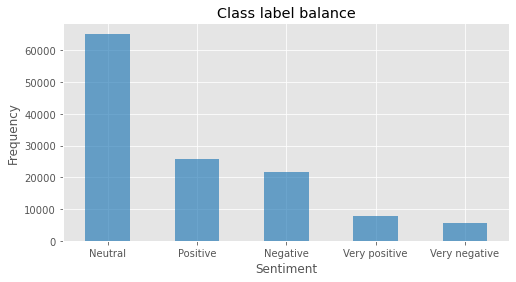

In [16]:
fig, ax = plt.subplots(figsize = (8,4))
ax = df['label'].sort_values(ascending=False).value_counts().plot(kind='bar', alpha=0.65)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Class label balance')

ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=0)

# Word Count

In [17]:
df['word_count'] = df['phrase_clean'].apply(lambda x: len(str(x).split()))

word_stats = df.groupby('label')['word_count']
word_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21837.0,5.080735,4.376612,1.0,2.0,3.0,7.0,30.0
Neutral,65287.0,2.920137,2.860092,1.0,1.0,2.0,3.0,28.0
Positive,25797.0,4.685971,4.168582,1.0,2.0,3.0,6.0,29.0
Very negative,5515.0,6.864551,5.063683,1.0,3.0,5.0,10.0,30.0
Very positive,7688.0,6.173777,4.801319,1.0,3.0,4.0,9.0,28.0


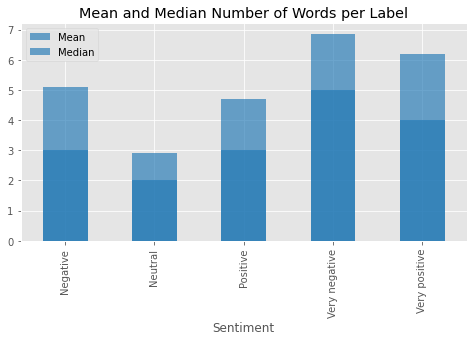

In [18]:
plot_stats(word_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Words per Label')

# Punctuation Count

In [19]:
df['punct_count'] = df['phrase'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [20]:
punct_stats = df.groupby('label')['punct_count']
punct_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21837.0,1.214269,1.763681,0.0,0.0,1.0,2.0,21.0
Neutral,65287.0,0.628778,1.217545,0.0,0.0,0.0,1.0,23.0
Positive,25797.0,1.041904,1.618260,0.0,0.0,0.0,1.0,17.0
Very negative,5515.0,1.825748,2.158380,0.0,0.0,1.0,3.0,17.0
Very positive,7688.0,1.457596,1.889155,0.0,0.0,1.0,2.0,18.0


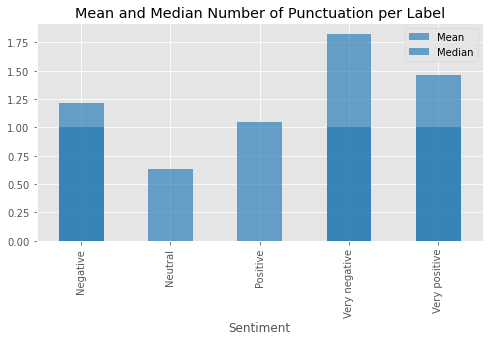

In [21]:
plot_stats(punct_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Punctuation per Label')

- Punctuation occurs more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other.

# Upper case letter count

In [22]:
df['num_caps'] = df['phrase_clean'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [23]:
numcap_stats = df.groupby('label')['punct_count']
numcap_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21837.0,1.214269,1.763681,0.0,0.0,1.0,2.0,21.0
Neutral,65287.0,0.628778,1.217545,0.0,0.0,0.0,1.0,23.0
Positive,25797.0,1.041904,1.618260,0.0,0.0,0.0,1.0,17.0
Very negative,5515.0,1.825748,2.158380,0.0,0.0,1.0,3.0,17.0
Very positive,7688.0,1.457596,1.889155,0.0,0.0,1.0,2.0,18.0


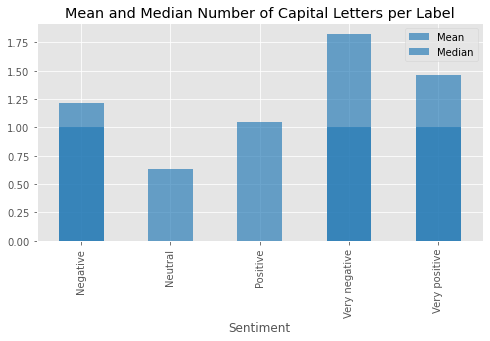

In [24]:
plot_stats(numcap_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Capital Letters per Label')

- Capital letters occur more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other, as well.

# Density plot of above stats

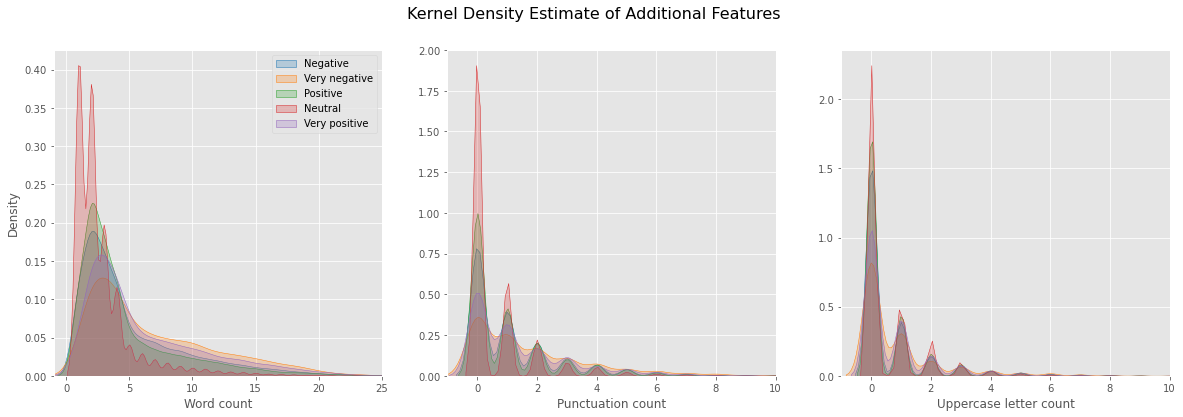

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Kernel Density Estimate of Additional Features', fontsize=16)

labels = df['label'].unique()

for i in labels:
    sns.kdeplot(df[df['label'] == i]['word_count'], ax=ax[0], shade=True)
    sns.kdeplot(df[df['label'] == i]['punct_count'], ax=ax[1], shade=True)
    sns.kdeplot(df[df['label'] == i]['num_caps'], ax=ax[2], shade=True)

ax[0].legend(df['label'].unique())
ax[0].set_xlabel('Word count')
ax[0].set_ylabel('Density')
ax[0].set_xlim(-1, 25)

ax[1].set_xlabel('Punctuation count')
ax[1].set_ylabel('')
ax[1].set_xlim(-1, 10)

ax[2].set_xlim(-1, 10)
ax[2].set_xlabel('Uppercase letter count')
ax[2].set_ylabel('')

plt.savefig('kde')

# Chi2 Features

In [4]:
train, validate, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=True)

  1%|▏         | 3473/239073 [00:00<00:06, 34723.16it/s]

Preprocessing...


100%|██████████| 239073/239073 [00:05<00:00, 41470.15it/s]


Deduplicating...


In [5]:
train.shape

(126124, 7)

In [6]:
X_train, y_train = train['phrase_clean'], train['label_id']
X_val, y_val = validate['phrase_clean'], validate['label_id']

In [7]:
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             max_features=10000, 
                             use_idf=True, 
                             ngram_range=(1,3))

In [8]:
vect = tfidf_vect.fit(X_train)
X_train_tfidf = vect.transform(X_train)
X_val_tfidf = vect.transform(X_val)

In [43]:
chi2score = chi2(X_train_tfidf, y_train)[0]

Text(0.5, 1.0, 'Top 10 $\\chi^2$ terms')

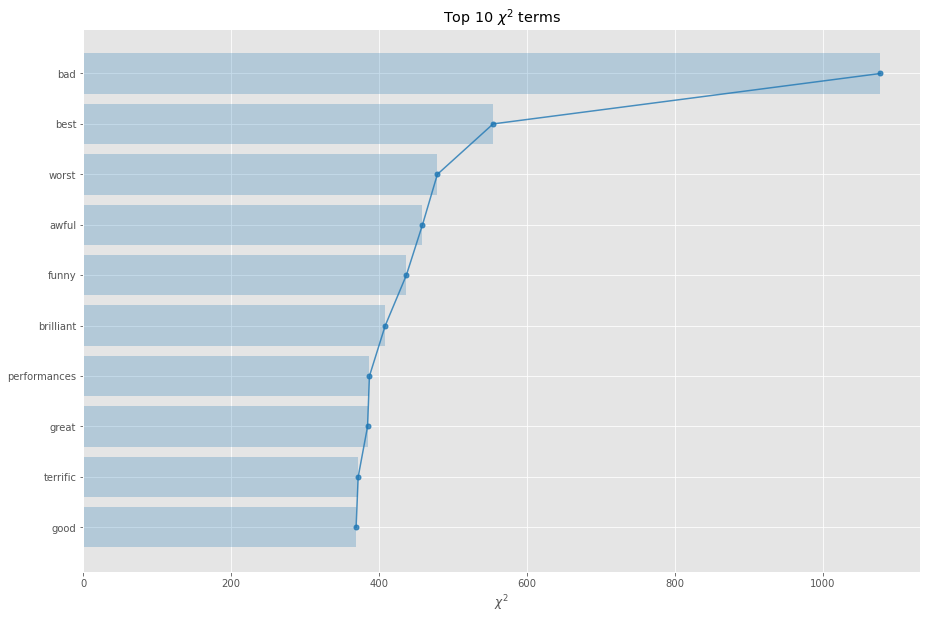

In [44]:
plt.figure(figsize=(15,10))
wscores = zip(tfidf_vect.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-10:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.25)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

plt.title('Top 10 $\chi^2$ terms')

#plt.savefig('x2', dpi=300)

# SVD

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [10]:
X_train_tfidf.shape

(126124, 10000)

In [11]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train_tfidf)

In [12]:
X_svd.shape

(126124, 2)

Text(0.5, 1.0, 'SVD on Movie Reviews')

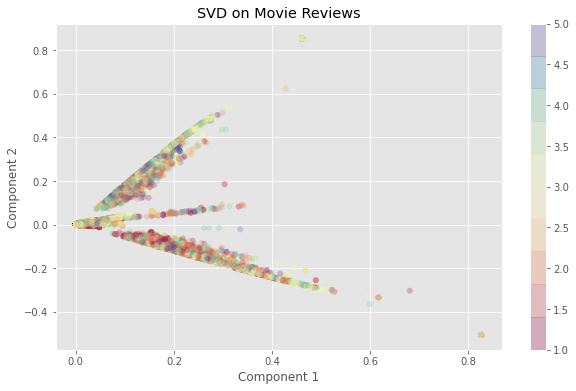

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=train['label_id'], 
            edgecolor='none', 
            alpha=0.25, 
            cmap=plt.get_cmap('Spectral', 10))
plt.colorbar()

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD on Movie Reviews')

In [43]:
X_dense = X_train_tfidf.toarray()

lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(X_dense, y_train)

In [48]:
lda_var_ratios = lda.explained_variance_ratio_

In [49]:
lda_var_ratios

array([0.53353601, 0.31026503, 0.08088438, 0.07531457])

In [50]:
lda.explained_variance_ratio_

array([0.53353601, 0.31026503, 0.08088438, 0.07531457])

In [54]:
0.53 + 0.31 + 0.08 + 0.07

0.99

In [51]:
select_n_components(lda_var_ratios, 0.95)

4

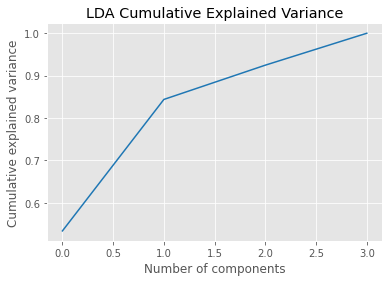

In [26]:
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('LDA Cumulative Explained Variance')
plt.savefig('lda', dpi=300)

In [27]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X_dense, y_train).transform(X_dense)

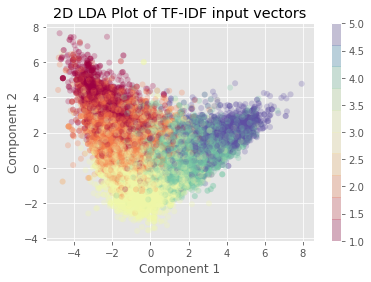

In [39]:
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=train['label_id'], 
            edgecolor='none', 
            alpha=0.25, 
            cmap=plt.get_cmap('Spectral', 10))

plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.title('2D LDA Plot of TF-IDF input vectors')
plt.savefig('lda-2d', dpi=300)